<a href="https://colab.research.google.com/github/Utree/deeplearning2_colab_log/blob/master/3%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 単語の分散表現 〜推論ベースの手法word2vec〜
カウントベースの手法では、周囲の単語の頻度によって、共起行列を作り、その行列に対して、SVDを適応することで、密なベクトル単語の分散表現を獲得しました。

しかし、カウントベースの手法には問題点があり、大規模なコーパスを扱う場合、巨大な行列を作ることになります。しかし、巨大な行列に対して、SVDを行うことは現実的ではありません。

## 推論ベースの手法

コンテキストが与えられたときに、どのような単語が出現するのかを推論する手法

推論問題を繰り返し解き、出現パーターンを学習する

モデルにコンテキストを入力として与えると、モデルは各単語の出現確率を出力する

one-hot表現で単語をベクトル表現で表すと

ニューラルネットワークを構成する様々な「レイヤ」によって処理することができる

In [1]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 入力
W = np.random.randn(7, 3) # 重み
# バイアスを用いいない全結合層のニューラルネット = 「行列の積」
h = np.dot(c, W) # 中間ノード
print(h)

# one-hotベクトルの積では、該当する重みの行ベクトルを抜き出すことに相当する

[[ 0.27538298 -1.58193412 -3.17133897]]


In [0]:
import numpy as np

In [0]:
class MatMul:
  '''
    MatMul(行列の積)レイヤ
  '''
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.x = None
    
  def forward(self, x):
    W, = self.params
    out = np.dot(x, W)
    self.x = x
    return out
  
  def backward(self, dout):
    W, = self.params
    dx = np.dot(dout, W.T)
    dW = np.dot(self.x.T, dout)
    self.grads[0][...] = dW
    return dx

In [4]:
# MatMulレイヤで実装
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.71588144  0.46093901 -1.41097394]]


word2vecでは、ニューラルネットワークのモデルにcontinuous bag-of-words(CBOW)を用いる

## CBOWのデータ処理構造

入力層でone-hot表現のベクトル受け取り、中間層で全結合による変換後の値の平均値を出し、出力層で、各単語のスコアを算出する

そのスコアにSoftmax関数を適応すると、確率が得られる

そして、この確率には、単語の意味もエンコードされている

In [5]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.74446532 -0.66704092  1.06909781  0.2488699   1.38501813  0.7607661
   0.77385235]]


In [0]:
import numpy as np

def preprocess(text):
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')
  
  word_to_id = {}
  id_to_word = {}
  for word in words:
    if word not in word_to_id:
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
  
  corpus = np.array([word_to_id[w] for w in words])
  
  return corpus, word_to_id, id_to_word

In [7]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [8]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [0]:
def create_contexts_target(corpus, window_size=1):
  target = corpus[window_size:-window_size]
  contexts = []
  
  for idx in range(window_size, len(corpus)-window_size):
    cs = []
    for t in range(-window_size, window_size + 1):
      if t == 0:
        continue
      cs.append(corpus[idx + t])
    contexts.append(cs)
  
  return np.array(contexts), np.array(target)

In [0]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [11]:
print(contexts)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]


In [12]:
print(target)

[1 2 3 4 1 5]


In [0]:
def convert_one_hot(corpus, vocab_size):
  '''one-hot表現への変換
  
  :param corpus: 単語IDのリスト(1次元もしくは2次元のNumPy配列)
  :param vocab_size: 語彙数
  :return: one-hot表現(2次元もしくは3次元のNumpy配列)
  '''
  N = corpus.shape[0]
  
  if corpus.ndim == 1:
    one_hot = np.zeros((N, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
      one_hot[idx, word_id] = 1
  
  elif corpus.ndim == 2:
    C = corpus.shape[1]
    one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
    for idx_0, word_ids in enumerate(corpus):
      for idx_1, word_id in enumerate(word_ids):
        one_hot[idx_0, idx_1, word_id] = 1
  
  return one_hot

In [0]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [0]:
import numpy as np

def softmax(x):
  if x.ndim == 2:
    x = x - x.max(axis=1, keepdims=True)
    x = np.exp(x)
    x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
    x = x - np.max(x)
    x = np.exp(x) / np.sum(np.exp(x))
    
  return x

def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
    
  # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
  if t.size == y.size:
    t = t.argmax(axis=1)
    
  batch_size = y.shape[0]
  
  return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [0]:
class MatMul:
  def __init__(self, W):
    self.params = [W]
    self.grads = [np.zeros_like(W)]
    self.x = None
    
  def forward(self, x):
    W, = self.params
    out = np.dot(x, W)
    self.x = x
    return out
  
  def backward(self, dout):
    W, = self.params
    dx = np.dot(dout, W.T)
    dW = np.dot(self.x.T, dout)
    self.grads[0][...] = dW
    return dx

In [0]:
class SoftmaxWithLoss:
  def __init__(self):
    self.params, self.grads = [], []
    self.y = None
    self.t = None
    
  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    
    # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
    if self.t.size == self.y.size:
      self.t = self.t.argmax(axis=1)
      
    loss = cross_entropy_error(self.y, self.t)
    return loss
  
  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    
    dx = self.y.copy()
    dx[np.arange(batch_size), self.t] -= 1
    dx *= dout
    dx = dx / batch_size
    
    return dx

In [0]:
class SimpleCBOW:
  def __init__(self, vocab_size, hidden_size):
    V, H = vocab_size, hidden_size
    
    # 重みの初期化
    W_in = 0.01 * np.random.randn(V, H).astype('f')
    W_out = 0.01 * np.random.randn(H, V).astype('f')
    
    # レイヤの生成
    self.in_layer0 = MatMul(W_in)
    self.in_layer1 = MatMul(W_in)
    self.out_layer = MatMul(W_out)
    self.loss_layer = SoftmaxWithLoss()
    
    # すべての重みと勾配をリストにまとめる
    layers = [self.in_layer0, self.in_layer1, self.out_layer]
    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads
      
    # メンバ変数に単語の分散表現を設定
    self.word_vecs = W_in
    
  def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    return loss
  
  def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da *= 0.5
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    return None

In [0]:
import numpy
import time
import matplotlib.pyplot as plt
import numpy

def clip_grads(grads, max_norm):
  total_norm = 0
  for grad in grads:
    total_norm += np.sum(grad ** 2)
  total_norm = np.sqrt(total_norm)
  
  rate = max_norm / (total_norm + 1e-6)
  if rate < 1:
    for grad in grads:
      grad *= rate

In [0]:
def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


In [0]:
class Trainer:
  def __init__(self, model, optimizer):
    self.model = model
    self.optimizer = optimizer
    self.loss_list = []
    self.eval_interval = None
    self.current_epoch = 0
    
  def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
    data_size = len(x)
    max_iters = data_size // batch_size
    self.eval_interval = eval_interval
    model, optimizer = self.model, self.optimizer
    total_loss = 0
    loss_count = 0
    
    start_time = time.time()
    for epoch in range(max_epoch):
      # シャッフル
      idx = numpy.random.permutation(numpy.arange(data_size))
      x = x[idx]
      t = t[idx]
      
      for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]
        
        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        params, grads = remove_duplicate(model.params, model.grads)
        # 共有された重みを1つに集約
        if max_grad is not None:
          clip_grads(grads, max_grad)
        optimizer.update(params, grads)
        total_loss += loss
        loss_count += 1
        
        # 評価
        if(eval_interval is not None) and (iters % eval_interval) == 0:
          avg_loss = total_loss / loss_count
          elapsed_time = time.time() - start_time
          print('| epoch %d | iter %d / %d | time %d[s] | loss %.2f'
                %(self.current_epoch + 1, iters + 1, max_iters,
                 elapsed_time, avg_loss))
          self.loss_list.append(float(avg_loss))
          total_loss, loss_count = 0, 0
          
      self.current_epoch +=1
      
  def plot(self, ylim=None):
    x = numpy.arange(len(self.loss_list))
    if ylim is not None:
      plt.ylim(*ylim)
    plt.plot(x, self.loss_list, label='train')
    plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
    plt.ylabel('loss')
    plt.show()

In [0]:
class Adam:
  '''
  Adam (http://arxiv.org/abs/1412.6980v8)
  '''
  def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
    self.lr = lr
    self.beta1 = beta1
    self.beta2 = beta2
    self.iter = 0
    self.m = None
    self.v = None
    
  def update(self, params, grads):
    if self.m is None:
      self.m, self.v = [], []
      for param in params:
        self.m.append(np.zeros_like(param))
        self.v.append(np.zeros_like(param))
        
    self.iter += 1
    lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
    
    for i in range(len(params)):
      self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
      self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
      
      params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

| epoch 1 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 2 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 3 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 4 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 5 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 6 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 7 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 8 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 9 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 10 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 11 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 12 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 13 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 14 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 15 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 16 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 17 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 18 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 19 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 20 | iter 1 / 1 | time 0[s] | loss 1.79
| epoch 21 | iter 1 / 1 | time 0[s] | loss 1.79
|

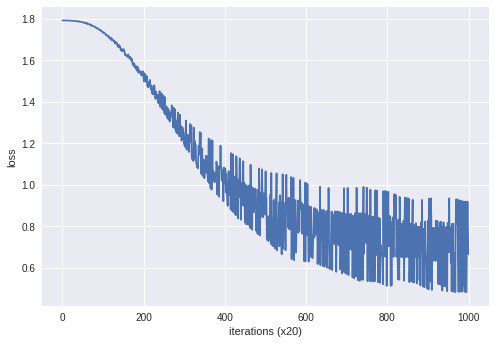

In [23]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [24]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
  print(word, word_vecs[word_id])

you [ 0.79927504 -0.941188    0.82642955  0.76557076 -0.84946984]
say [-0.8203432  -0.9735661  -0.81836295 -0.83937687  0.8166195 ]
goodbye [ 0.7416605  -0.6130347   0.73302007  0.7558204  -0.65633756]
and [-0.8120822  -0.9872426  -0.823234   -0.8404246   0.81870663]
i [ 0.7181531  -0.564209    0.71903753  0.72238237 -0.6436246 ]
hello [ 0.8155345  -0.9283557   0.81489     0.76903975 -0.8401285 ]


目的: 単語の分散表現を得たい

手法:
1. カウントベースの手法
2. 推論ベースの手法(word2vec)

1. カウントベースの手法では、周囲の単語の頻度によって、共起行列を作り、その行列に対して、SVDを適応することで、密なベクトル単語の分散表現を獲得する。

2. 推論ベースの手法では、推論することを目標として、その副産物として、単語の分散表現を得る

単語の類似性に関する定量評価に関して言えば、推論ベースとカウントベースの手法には優劣がつけられない

word2vecでは、類似性に加えて、複雑な単語間のパターンも捉えることができる。

推論ベースの手法では、パラメータの再学習を行うことができる。

推論ベースの手法(word2vec) : 

i. skip-gramモデル

ii. CBOWモデル



i. skip-gramでは、一つの単語(ターゲット)から、複数の単語(コンテキスト)を推測する。



ii. CBOWでは、複数の単語(コンテキスト)から一つの単語(ターゲット)を推測する

**word2vecは重みの再学習を行えるので、単語の分散表現の更新や、追加を効率的に行える**